# Coursework for Artificial Intelligence H COMPSCI4004 2024-2025

## Imports

In [237]:
import os, sys
import networkx as nx
from mazelib import Maze
from mazelib.generate.Prims import Prims
import numpy as np
import random as rand

import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

print("Python version:", sys.version)
print("Networkx version:", nx.__version__)
print("IPyWidgets version:", widgets.__version__)

Python version: 3.13.0 | packaged by Anaconda, Inc. | (main, Oct  7 2024, 21:29:38) [GCC 11.2.0]
Networkx version: 3.4.2
IPyWidgets version: 8.1.5


In [238]:
# To import the AIMA toolbox, add path the to the AIMA Python Toolbox folder on your system
AIMA_TOOLBOX_ROOT="/home/valeria/Documents/Code/aima-python-uofg_v20202021a"
sys.path.append(AIMA_TOOLBOX_ROOT)

import search as sch
from notebookutils import show_map, display_visual
# Needed to hide warnings in the matplotlib sections

## Parameters

In [239]:
N = 9 # Number of tiles on the side
M = 3 # Number of wormholes

In [240]:
# Maze will have shape (N,N) counting walls ==> N needs to be an odd number
assert N % 2 == 1, "N needs to be an odd number"
# Entrance and exit are in the walls

## Maze Generation

### Generate a random maze

In [241]:
# rand.seed(32)

In [242]:
m = Maze( )
m.generator = Prims(int(N/2), int(N/2))
m.generate()
m.generate_entrances(True, True)
print(m)
print(len(m.grid))

#########
E   #   #
# # ### #
# #   # #
### ### #
#       S
# ##### #
#   #   #
#########
9


In [243]:
m.grid

array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 1, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int8)

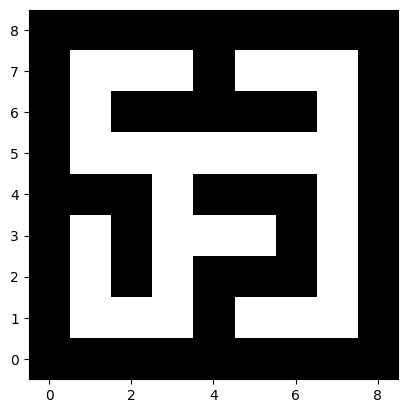

In [244]:
plt.imshow(np.logical_not(m.grid), cmap="gray", origin="lower")

### Get a grid with entrance and exit

In [245]:
maze_grid = np.logical_not(m.grid)*2
maze_grid[m.start] = 1
maze_grid[m.end] = 3
maze_grid = maze_grid.astype(np.uint8)
# Probably won't be able to have more than 2**8-3 wormholes

n = len(maze_grid)

In [246]:
maze_grid

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 2, 2, 2, 0, 2, 2, 2, 0],
       [0, 2, 0, 2, 0, 0, 0, 2, 0],
       [0, 2, 0, 2, 2, 2, 0, 2, 0],
       [0, 0, 0, 2, 0, 0, 0, 2, 0],
       [0, 2, 2, 2, 2, 2, 2, 2, 1],
       [0, 2, 0, 0, 0, 0, 0, 2, 0],
       [0, 2, 2, 2, 0, 2, 2, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

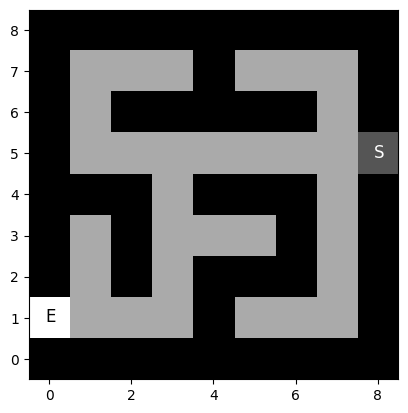

In [247]:
plt.imshow(maze_grid, cmap="gray", origin="lower")
for (j, i), label, color in zip([m.start, m.end], ["S","E"], ["w", "k"]):
    plt.text(i-.1, j-.1, label, color=color, fontsize="large")

### Generate wormholes

#### Some helper functions

In [248]:
def square2flat(i, j, N):
    """From indices in a square array, to index in flatten array"""
    return i*N + j

def flat2square(k, N):
    """From indices in a flatten array, to index in square array"""
    return (k // N, k % N)

def square_neighbours(k, N):
    """Return neighbours in a squared array while working with flatten indices"""
    i, j = flat2square(k, N)
    neighbours = []
    if i>0: neighbours.append(k-N)
    if i<N-1: neighbours.append(k+N)
    if j>0: neighbours.append(k-1)
    if j<N-1: neighbours.append(k+1)
    return neighbours    

In [249]:
print(flat2square(15,N))
print(flat2square(16,N))

(1, 6)
(1, 7)


In [250]:
index = square2flat(1,7,N)

print("Flat index", index)
print("Square array indices", flat2square(index, N))
print("Neighbours' flat indices", square_neighbours(index, N))
print("Neighbours' square indices", [flat2square(k, N) for k in square_neighbours(index, N)])

Flat index 16
Square array indices (1, 7)
Neighbours' flat indices [7, 25, 15, 17]
Neighbours' square indices [(0, 7), (2, 7), (1, 6), (1, 8)]


#### Wormhole indices selection

In [251]:
# Available tiles for wormhole entrances
indices_available = np.where(maze_grid.flatten()==2)[0].tolist()
n_available = len(indices_available)
assert n_available >= 2*M, "Not enough empty tiles for that many wormholes"


In [252]:
# Randomize positions
rand.shuffle(indices_available)
# indices_available = [16, 15, 67, 64, 25, 55, 14, 29, 49, 10, 48, 11, 43, 59, 51, 32, 34, 19, 13, 69, 30, 23, 66, 12, 68, 37, 50, 46, 28, 70, 52]

# Make sure that wormholes are not formed between neighbours
wormholes = []
filled = False
# print(indices_available)
while not filled:
    if len(wormholes)%2 == 0:
        add_candidate = True
    else:
        # print("Wormholes so far are", wormholes)
        # print("Current candidate is", indices_available[0])
        # print("Last added wormhole is", wormholes[-1])
        # print("Neighbours are", square_neighbours(wormholes[-1], N))
        if indices_available[0] not in square_neighbours(wormholes[-1], N):
            add_candidate = True
        else: 
            # print("Is a neighbour in", square_neighbours(wormholes[-1], N))
            add_candidate = False
    if add_candidate:
        wormholes.append( indices_available.pop(0) )
    else:
        indices_available.append( indices_available.pop(0) )
    # print(indices_available)
    filled = len(wormholes) == 2*M

In [253]:
wormholes

[34, 10, 19, 31, 25, 32]

In [254]:
[flat2square(w_k, N) for w_k in wormholes]

[(3, 7), (1, 1), (2, 1), (3, 4), (2, 7), (3, 5)]

### Visualization

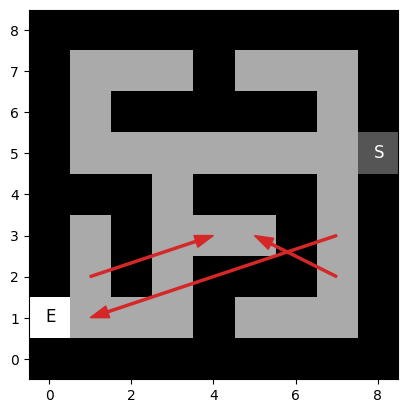

In [255]:
plt.imshow(maze_grid, cmap="gray", origin="lower")
for w_k in range(M):
    i_start, j_start = flat2square(wormholes[2*w_k], N)
    i_end, j_end = flat2square(wormholes[2*w_k+1], N)
    plt.arrow(j_start, i_start, j_end-j_start, i_end-i_start,
              width=0.05, head_width=0.3, length_includes_head=True,
              color="C3")
for (j, i), label, color in zip([m.start, m.end], ["S","E"], ["w", "k"]):
    plt.text(i-.1, j-.1, label, color=color, fontsize="large")

### Graph representation of the maze

In [256]:
tile2str = lambda i, j : f"S_{i:02d}_{j:02d}"

In [257]:
network_dict = {}
map_locations = {}
for i in range(N):
    for j in range(N):
        if maze_grid[i,j]: 
            cell_dict = {}
            if i>0 and maze_grid[i-1,j]: cell_dict[ tile2str(j,i-1) ] = 1
            if i<N-1 and maze_grid[i+1,j]: cell_dict[ tile2str(j,i+1) ] = 1
            if j>0 and maze_grid[i,j-1]: cell_dict[ tile2str(j-1,i) ] = 1
            if j<N-1 and maze_grid[i,j+1]: cell_dict[ tile2str(j+1,i) ] = 1
            network_dict[ tile2str(j,i) ] = cell_dict
            map_locations[ tile2str(j,i) ] = (j,i)

maze_start = tile2str(*m.start[::-1])
maze_end = tile2str(*m.end[::-1])

In [258]:
if M>0:
    for w_k in range(M):
        i_start, j_start = flat2square(wormholes[2*w_k], N)
        i_end, j_end = flat2square(wormholes[2*w_k+1], N)
        network_dict[ tile2str(j_start,i_start) ][ tile2str(j_end,i_end) ] = 1

In [259]:
network_dict

{'S_00_01': {'S_01_01': 1},
 'S_01_01': {'S_01_02': 1, 'S_00_01': 1, 'S_02_01': 1},
 'S_02_01': {'S_01_01': 1, 'S_03_01': 1},
 'S_03_01': {'S_03_02': 1, 'S_02_01': 1},
 'S_05_01': {'S_06_01': 1},
 'S_06_01': {'S_05_01': 1, 'S_07_01': 1},
 'S_07_01': {'S_07_02': 1, 'S_06_01': 1},
 'S_01_02': {'S_01_01': 1, 'S_01_03': 1, 'S_04_03': 1},
 'S_03_02': {'S_03_01': 1, 'S_03_03': 1},
 'S_07_02': {'S_07_01': 1, 'S_07_03': 1, 'S_05_03': 1},
 'S_01_03': {'S_01_02': 1},
 'S_03_03': {'S_03_02': 1, 'S_03_04': 1, 'S_04_03': 1},
 'S_04_03': {'S_03_03': 1, 'S_05_03': 1},
 'S_05_03': {'S_04_03': 1},
 'S_07_03': {'S_07_02': 1, 'S_07_04': 1, 'S_01_01': 1},
 'S_03_04': {'S_03_03': 1, 'S_03_05': 1},
 'S_07_04': {'S_07_03': 1, 'S_07_05': 1},
 'S_01_05': {'S_01_06': 1, 'S_02_05': 1},
 'S_02_05': {'S_01_05': 1, 'S_03_05': 1},
 'S_03_05': {'S_03_04': 1, 'S_02_05': 1, 'S_04_05': 1},
 'S_04_05': {'S_03_05': 1, 'S_05_05': 1},
 'S_05_05': {'S_04_05': 1, 'S_06_05': 1},
 'S_06_05': {'S_05_05': 1, 'S_07_05': 1},
 'S_07

In [260]:
map_locations

{'S_00_01': (0, 1),
 'S_01_01': (1, 1),
 'S_02_01': (2, 1),
 'S_03_01': (3, 1),
 'S_05_01': (5, 1),
 'S_06_01': (6, 1),
 'S_07_01': (7, 1),
 'S_01_02': (1, 2),
 'S_03_02': (3, 2),
 'S_07_02': (7, 2),
 'S_01_03': (1, 3),
 'S_03_03': (3, 3),
 'S_04_03': (4, 3),
 'S_05_03': (5, 3),
 'S_07_03': (7, 3),
 'S_03_04': (3, 4),
 'S_07_04': (7, 4),
 'S_01_05': (1, 5),
 'S_02_05': (2, 5),
 'S_03_05': (3, 5),
 'S_04_05': (4, 5),
 'S_05_05': (5, 5),
 'S_06_05': (6, 5),
 'S_07_05': (7, 5),
 'S_08_05': (8, 5),
 'S_01_06': (1, 6),
 'S_07_06': (7, 6),
 'S_01_07': (1, 7),
 'S_02_07': (2, 7),
 'S_03_07': (3, 7),
 'S_05_07': (5, 7),
 'S_06_07': (6, 7),
 'S_07_07': (7, 7)}

In [261]:
teleportation_links = []
for w_ij in wormholes:
    i, j = flat2square(w_ij, N)
    teleportation_links.append( tile2str(j,i) )

In [262]:
teleportation_links

['S_07_03', 'S_01_01', 'S_01_02', 'S_04_03', 'S_07_02', 'S_05_03']

Important personal interpretation
- I am assuming that going down a teleportation link is optional: e.g. in (2,1) it's possible to go right, go left, or go down the teleportation link.
- I am assuming that the wormholes are two-ways passages: e.g. from (2,1) you can go down the teleportation link to (0,7), and from (0,7) you can go back to (2,1).


- Environment? Besides being discrete and static, it is...
    - Deterministic, because wormholes might lead to an unknown state, but they always lead to the same state with 100% probability.
    - Partially observable, because it is not known from the percepts where the "teleport" action is going to take the agent.
- Actuators? Move the agent according to 5 possible actions:
    - Left
    - Right
    - Up
    - Down
    - Teleport
- Percepts? 
    - Current x,y location
    - Feasibility of all 5 actions, expressed by booleans (l,r,u,d,t)
- Sensors? Incomplete because...
    - The agent knows to which state the (Left, Right, Up, Down) actions take it
    - But the agent does not know to which state the (Teleport) action takes it
- Performance measure? The sortest the path to goal, the better (in terms of steps taken from the start point)

In [263]:
maze_map = sch.Graph(network_dict)
maze_map.locations = map_locations

In [264]:
print("Unique states/nodes (i.e.locations) and possible actions in those states:\n") 
print(maze_map.locations) 

Unique states/nodes (i.e.locations) and possible actions in those states:

{'S_00_01': (0, 1), 'S_01_01': (1, 1), 'S_02_01': (2, 1), 'S_03_01': (3, 1), 'S_05_01': (5, 1), 'S_06_01': (6, 1), 'S_07_01': (7, 1), 'S_01_02': (1, 2), 'S_03_02': (3, 2), 'S_07_02': (7, 2), 'S_01_03': (1, 3), 'S_03_03': (3, 3), 'S_04_03': (4, 3), 'S_05_03': (5, 3), 'S_07_03': (7, 3), 'S_03_04': (3, 4), 'S_07_04': (7, 4), 'S_01_05': (1, 5), 'S_02_05': (2, 5), 'S_03_05': (3, 5), 'S_04_05': (4, 5), 'S_05_05': (5, 5), 'S_06_05': (6, 5), 'S_07_05': (7, 5), 'S_08_05': (8, 5), 'S_01_06': (1, 6), 'S_07_06': (7, 6), 'S_01_07': (1, 7), 'S_02_07': (2, 7), 'S_03_07': (3, 7), 'S_05_07': (5, 7), 'S_06_07': (6, 7), 'S_07_07': (7, 7)}


#### Visualization

In [265]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in maze_map.locations.keys()}
node_positions = maze_map.locations
node_label_pos = { k:[v[0],v[1]-.3]  for k,v in maze_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in maze_map.graph_dict.items() for k2, v2 in v.items()}

maze_graph_data = {  'graph_dict' : maze_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                        'edge_weights': edge_weights
                     }

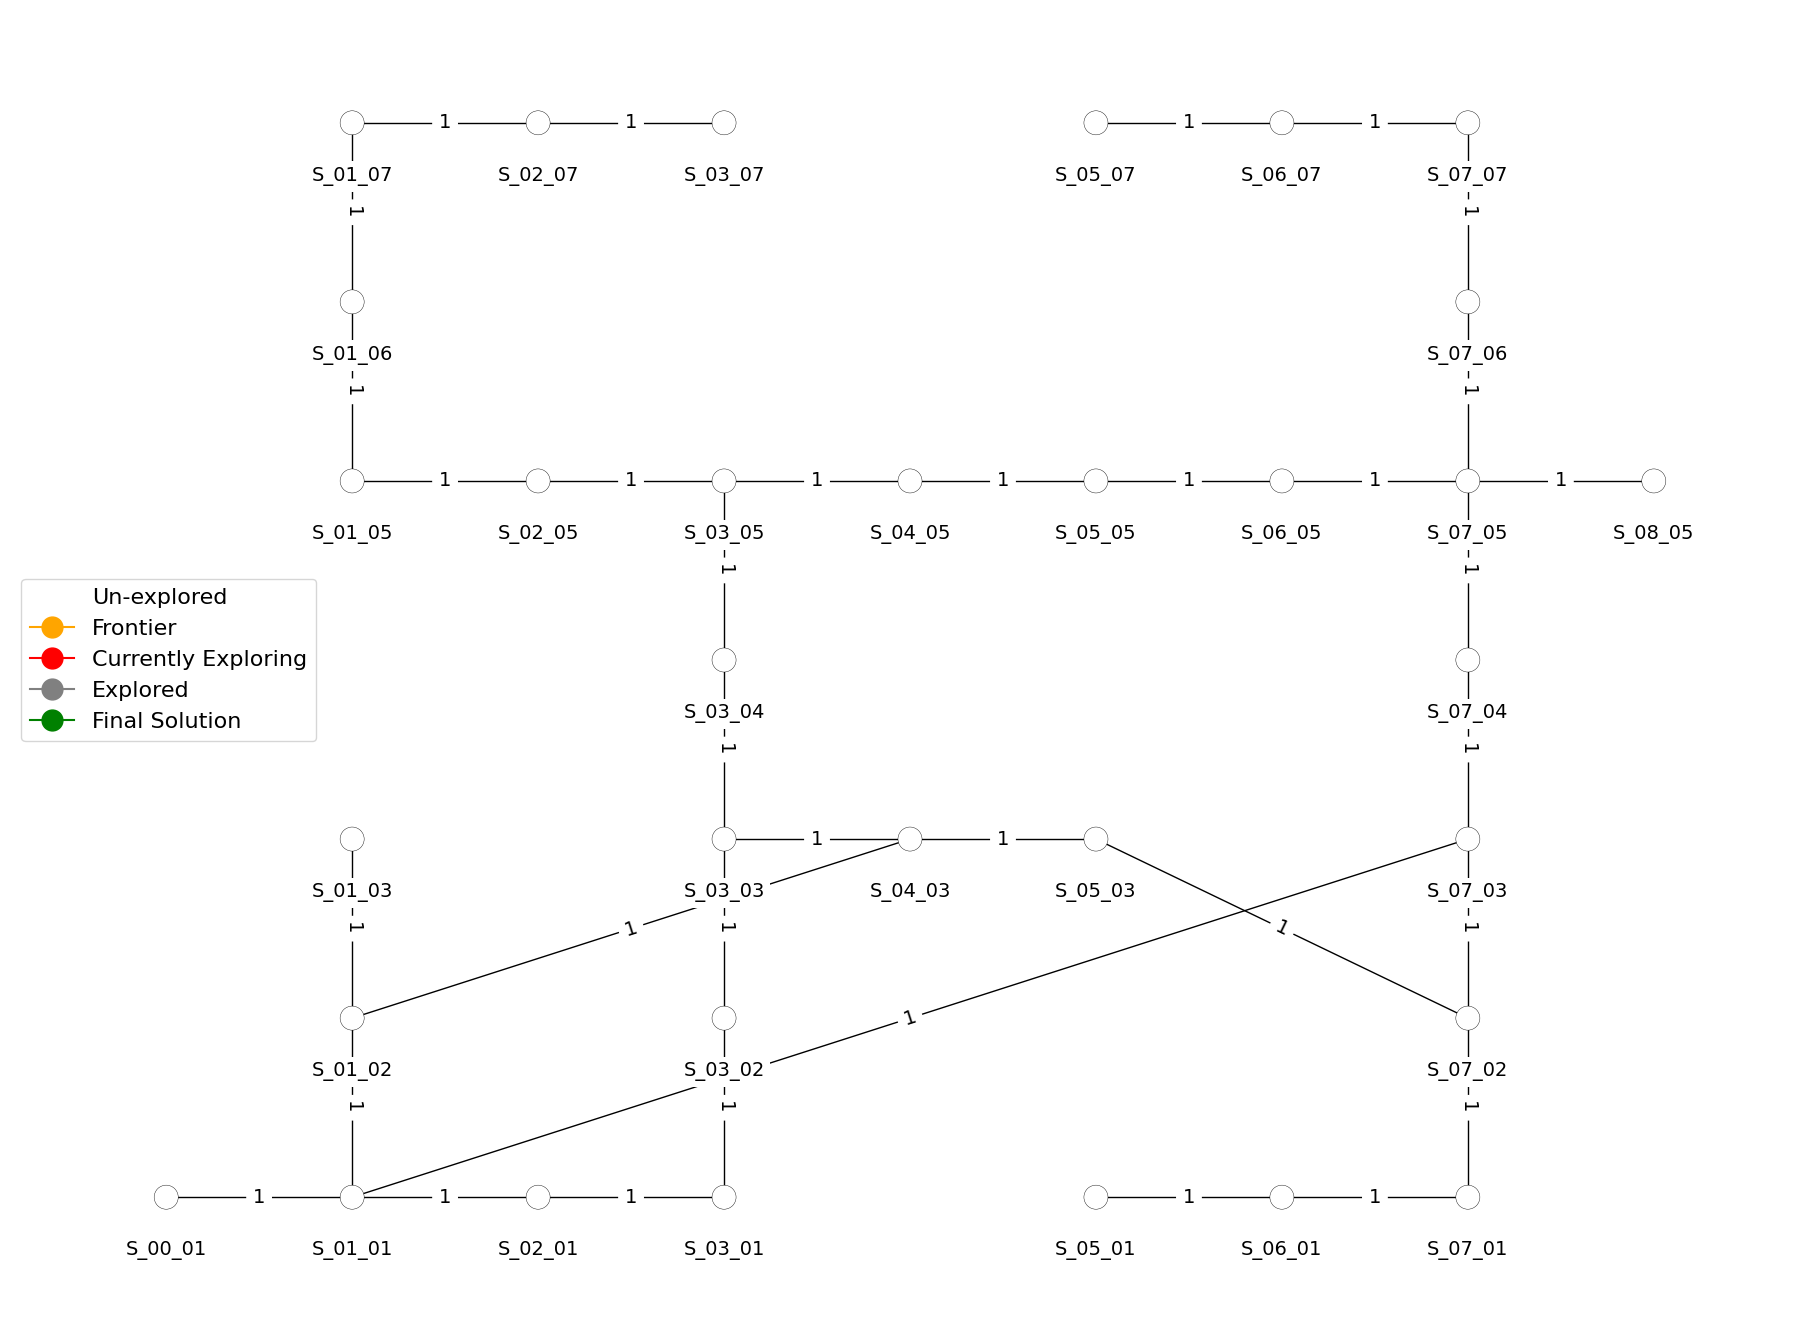

In [266]:
show_map(maze_graph_data)

## Solve the problem (v1.1)

### Define the problem with no knowledge of the wormholes' exit

The A-star algorithm will always reach optimal solution if the heuristic function is admissible. 

A heuristic function is admissible if it never overestimates the cost to reach a goal. Meaning, an admissible h is optimistic, returning the estimated cost of the cheapest/shortest path from a state to the goal.

An agent at the start of a teleportation link can choose to go down the wormhole. However, it cannot know in advance where the exit is.

The most optimistic case going down a wormhole will always assume that a wormhole can take you right to the exit.


After playing around with implementation 1.0, I realized I wasn't updating the preference order of wormholes after discovering them. This implementation 1.1 fixes that.

In [267]:
class WormholesGraphProblem(sch.GraphProblem):
    """The problem of searching a graph with teleportation links.
    
    An agent at the start of a teleportation link can choose to go down the wormhole.
    However, it cannot know in advance where the exit is"""

    def __init__(self, start, end, map, wormholes, verbose=False):
        super().__init__(start, end, map)
        self.wormholes = wormholes
        self.verbose = verbose

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def is_wormhole(self, node, parent):
        if type(node) is not str:
            node = node.state
        if parent and type(parent) is not str:
            parent = parent.state
        if parent and node in self.wormholes:
            index = self.wormholes.index(node)
            if index>0 and parent==self.wormholes[index-1]:
                if self.verbose: print("Teleportation link")
                return True
        return False

    def h(self, node, is_unknown=False):
        """The sum of the horizontal and vertical distance to the goal"""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is not str:
                node = node.state
            position_node = np.array(locs[node])
            position_goal = np.array(locs[self.goal])
            if self.verbose: print("Node position", position_node)
            # The most optimistic assumption is that a wormhole will take you right adjacent to the goal
            if is_unknown:
                if self.verbose: print("Unknown distance to the goal")
                return 1 
            if self.verbose: print("Distance to the goal", int( np.sum( np.abs( position_goal - position_node) ) ))
            return int( np.sum( np.abs( position_goal - position_node) ) )
        else:
            return sch.infinity

In [268]:
maze_problem = WormholesGraphProblem(maze_start, maze_end, maze_map, teleportation_links, verbose=True)

print("Initial state:", maze_problem.initial)
print("Goal state:", maze_problem.goal)
print("Teleportation links:", maze_problem.wormholes)

Initial state: S_08_05
Goal state: S_00_01
Teleportation links: ['S_07_03', 'S_01_01', 'S_01_02', 'S_04_03', 'S_07_02', 'S_05_03']


In [269]:
maze_problem.h(maze_problem.wormholes[1], 
               is_unknown=maze_problem.is_wormhole(*maze_problem.wormholes[:2][::-1]))
# maze_problem.h(*maze_problem.wormholes[:2][::-1])

Teleportation link
Node position [1 1]
Unknown distance to the goal


1

In [270]:
maze_problem.h(maze_problem.wormholes[1], is_unknown=False)

Node position [1 1]
Distance to the goal 1


1

### Generalize A-star

In [271]:
import heapq
from aimautils import PriorityQueue

class MyPriorityQueue(PriorityQueue):
    """A Queue in which elements are returned ordered according to an f value.
    
    If order is 'min', the item with minimum f is returned first; if order is 
    'max', then it is the item with maximum f. Also supports dict-like lookup.

    In contrast with AIMA's implementation...
    ...This queue doesn't automatically calculate `f(input)`: it needs 
    `f(input), input` as the input to the `append` method
    ...This queue is built to have `input = node, parent`, storing two 
    elements associated to `f(input)` instead of one; i.e. each element in the 
    queue is `f(node), node, parent` instead of just `f(node), node`"""

    def __init__(self, order='min'):
        assert order in ["min", "max"], "Needs to be 'min' or 'max'"
        self.order = order
        self.heap = []

    def append(self, f_value, node, parent):
        """Insert item at its correct position."""
        if self.order == 'min':
            heapq.heappush(self.heap, (f_value, node, parent))
        elif self.order == 'max':  # now item with max f(x)
            heapq.heappush(self.heap, (-f_value, node, parent))  # will be popped first

    def extend(self, f_values, nodes, parents):
        """Insert each item in items at its correct position."""
        for f_value, node, parent in zip(f_values, nodes, parents):
            self.append(f_value, node, parent)

    def pop(self):
        """Pop and return the item with min or max f(x) value
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __contains__(self, node):
        """Return True if item in PriorityQueue."""
        nodes = [n for (f, n, p) in self.heap]
        return n in nodes

    def __getitem__(self, node):
        for f, n, p in self.heap:
            if n==node:
                return f, n, p

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        nodes = [n for (f, n, p) in self.heap]
        index = nodes.index(n)
        self.heap.remove(self.heap[index])
        heapq.heapify(self.heap)

    def update_item(self, f_value, node, parent, new_f_value):
        """Delete the first occurrence of key."""
        index = self.heap.index((f_value, node, parent))
        self.heap.remove(self.heap[index])
        self.heap.append(new_f_value, node, parent)
        heapq.heapify(self.heap)

In [272]:
def wormholes_maze_A_star_solver(maze_problem, verbose=True):
    """Search the nodes with the lowest f scores first.

    The scoring function f(x) is calculating adding up...
    ...the path cost g(x) calculated using the weights in the network links
    ...the heuristic function h(x) returing the euclidean distance for 
    known distances, and 1 for unknown distances such as those in wormholes
    
    Partial credit to the AI Module lecturers: this function has been 
    taken from Lab 3 before being modified.
    
    In contrast with the original...
    ...This function stores both node and parent inside of the queue
    ...It requires `DoublePriorityQueue` to work
    ...It also requires `WormholesGraphProblem`, because it uses its 
    `is_wormhole` and the `is_unknown` optional argument included inside 
    its `h` function
    ...The unknown values are replaced during exploration with known values
    ...This function contains plenty of annotations to describe the progress 
    while running
    """
    
    def comment(*args):
        if verbose: print(*args)
    maze_problem.verbose = verbose

    # we use these two variables at the time of visualisations
    iterations = 0
    comment(">> Iteration", iterations, ">> Setting up the problem")
    all_node_colors = []
    node_colors = {k : 'white' for k in maze_problem.graph.nodes()}
    
    iterations += 1
    comment(">> Iteration", iterations, ">> Adding the start point")
    node = sch.Node(maze_problem.initial)
    node_colors[node.state] = "green"    
    all_node_colors.append(dict(node_colors))
    
    if maze_problem.goal_test(node.state):
        node_colors[node.state] = "limegreen"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = MyPriorityQueue('min')
    frontier.append(0, node, None)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:

        comment(">> Iteration", iterations, ">> Exploring a node in the frontier")
        f_value, node, parent = frontier.pop()
        comment("== Node", (f_value, node, parent), "popped out")
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        explored.add(node.state)
        if parent and maze_problem.is_wormhole(node, parent):
            comment(">> Iteration", iterations, ">> Updating", node, "with parent", parent)
            h_value = maze_problem.h(node, is_unknown=False)
            updated_f_value = f_value - 1 + h_value # Subtract 1 because that was the h value while still unknown
            comment(frontier.heap)
            frontier.append(updated_f_value, node, parent)
            iterations += 1
        
        if maze_problem.goal_test(node.state):
            comment(">> Iteration", iterations, ">> Goal has been found")
            node_colors[node.state] = "limegreen"
            node_colors[maze_problem.initial] = "limegreen"
            for extra_node in node.solution():
                node_colors[extra_node] = "limegreen"  
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)

        comment("Will go over the following childs:", node.expand(maze_problem))
        for child in node.expand(maze_problem):
            comment("== Child", child)
            if child.state not in explored and child not in frontier:
                comment(">> Iteration", iterations, ">> Adding that child to the frontier")
                child_h_value = maze_problem.h(node, is_unknown=maze_problem.is_wormhole(child, node))
                child_f_value = child.path_cost  + child_h_value
                frontier.append(child_f_value, child, node)
                comment("Added", (child_f_value, child, node))
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                comment(">> Iteration", iterations, ">> Detected that child already inside the frontier")
                incumbent_f_value, incumbent_node, incumbent_parent = frontier[child]
                child_h_value = maze_problem.h(node, is_unknown=maze_problem.is_wormhole(child, node))
                child_f_value = child.path_cost  + child_h_value
                comment("Examining previous", (incumbent_f_value, incumbent_node, incumbent_parent))
                if child_f_value < incumbent_f_value:
                    del frontier[incumbent_node]
                    frontier.append(child_f_value, child, node)
                    comment("= Removed that and added", (child_f_value, child, node), "instead")
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                else:
                    comment("= Kept", (incumbent_f_value, incumbent_node, incumbent_parent))
            else:
                comment("Child had already been explored")

        comment(">> Iteration", iterations, ">> Finished exploring a node")
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        comment("Current queue", frontier.heap)
    return None


### Run the solver

In [273]:
all_node_colors=[]
iterations, all_node_colors, node = wormholes_maze_A_star_solver(maze_problem)

#-- Trace the solution --#
solution_path = [node]
cnode = node.parent
solution_path.append(cnode)
while cnode.state != maze_start:
    cnode = cnode.parent  
    solution_path.append(cnode)

print("----------------------------------------")
print("Identified goal state:"+str(solution_path[0]))
print("----------------------------------------")
print("Solution trace:"+str(solution_path))
print("----------------------------------------")


>> Iteration 0 >> Setting up the problem
>> Iteration 1 >> Adding the start point
>> Iteration 2 >> Exploring a node in the frontier
== Node (0, <Node S_08_05>, None) popped out
Will go over the following childs: [<Node S_07_05>]
== Child <Node S_07_05>
>> Iteration 3 >> Adding that child to the frontier
Node position [8 5]
Distance to the goal 12
Added (13, <Node S_07_05>, <Node S_08_05>)
>> Iteration 4 >> Finished exploring a node
Current queue [(13, <Node S_07_05>, <Node S_08_05>)]
>> Iteration 5 >> Exploring a node in the frontier
== Node (13, <Node S_07_05>, <Node S_08_05>) popped out
Will go over the following childs: [<Node S_07_04>, <Node S_07_06>, <Node S_06_05>, <Node S_08_05>]
== Child <Node S_07_04>
>> Iteration 6 >> Adding that child to the frontier
Node position [7 5]
Distance to the goal 11
Added (13, <Node S_07_04>, <Node S_07_05>)
== Child <Node S_07_06>
>> Iteration 7 >> Adding that child to the frontier
Node position [7 5]
Distance to the goal 11
Added (13, <Node S_0

### Visualization

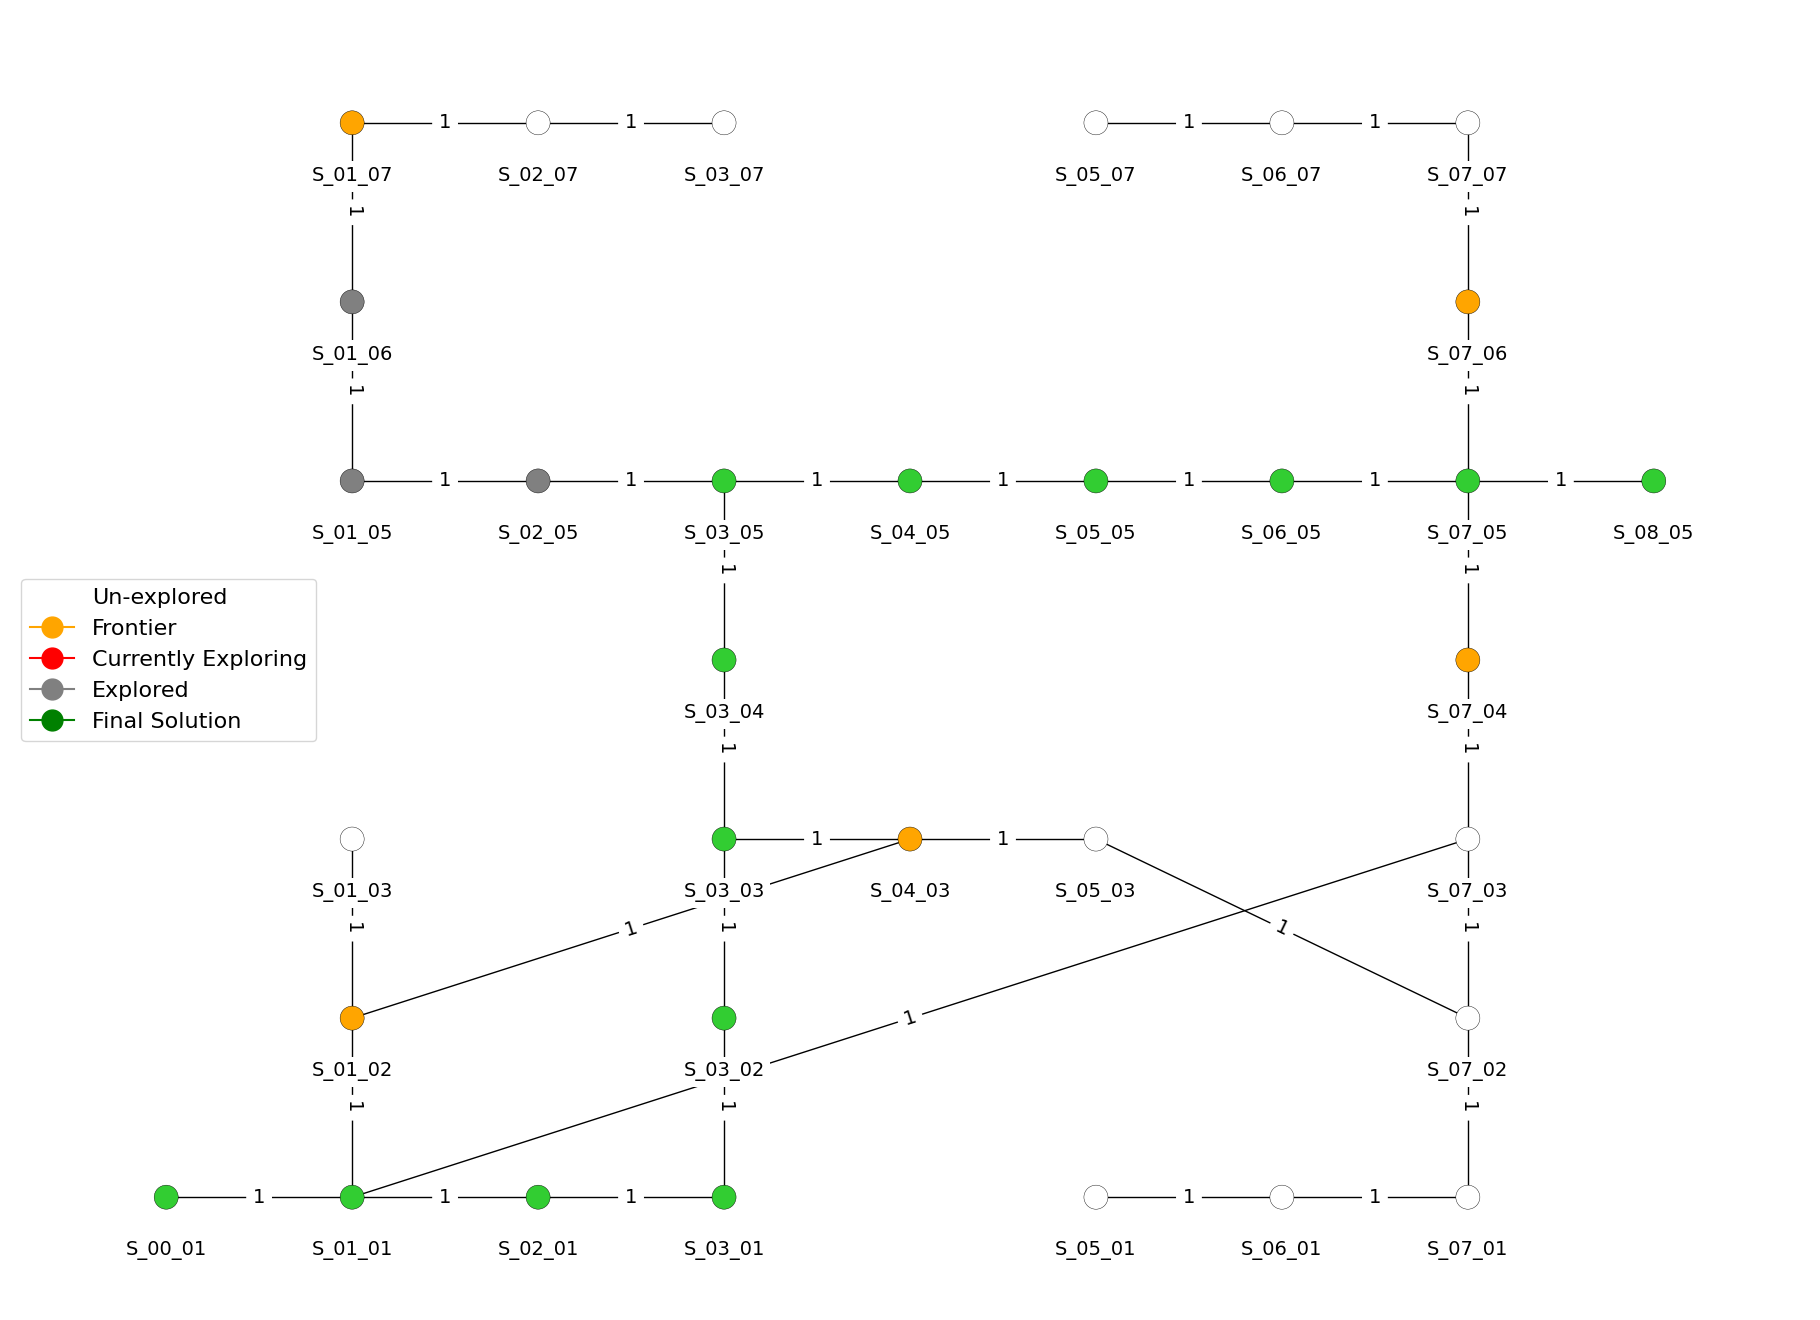

In [274]:
final_maze_graph_data = dict(maze_graph_data)
final_maze_graph_data["node_colors"] = all_node_colors[-1]

show_map(final_maze_graph_data)

In [ ]:
do_full_visualization = False
if do_full_visualization:     
    # WARNING the FULL visualisation might not work very well on some computers due to 
    # the large graph and the many iterations required.The visualisaiton will 
    # typically compute the solution and do the plotting at the end - and it often takes a long time ...
    #
    print("::: Full Visualization ::::")
    maze_problem.verbose = False
    all_node_colors = []        
    display_visual(maze_graph_data, user_input=False, 
                   algorithm=lambda problem : wormholes_maze_A_star_solver(problem, verbose=False), 
                   problem=maze_problem)
    maze_problem.verbose = True

::: Full Visualization ::::


interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Analysis

**I'm now updating my h after exploring the wormhole**

Ouch! Never got to explore the upper path and find the shortcut

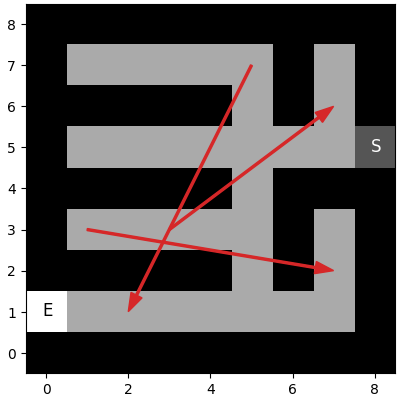

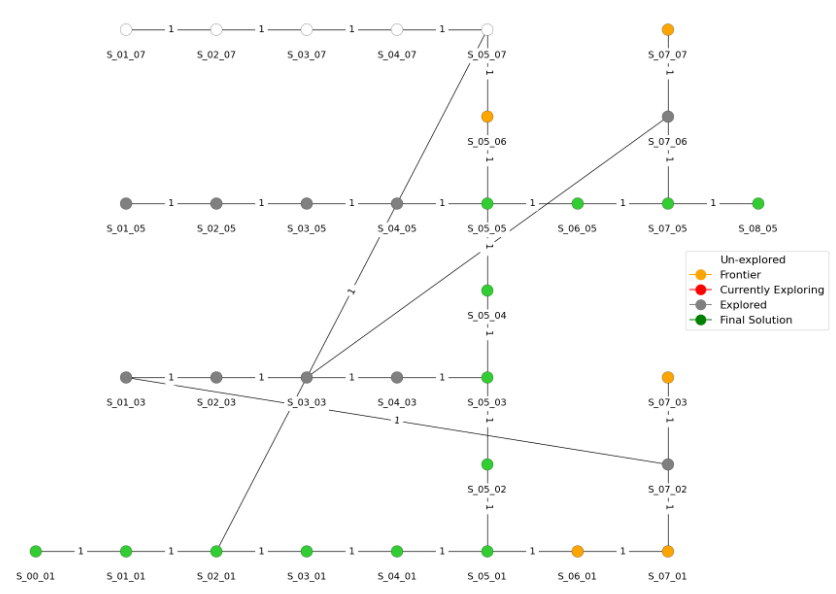

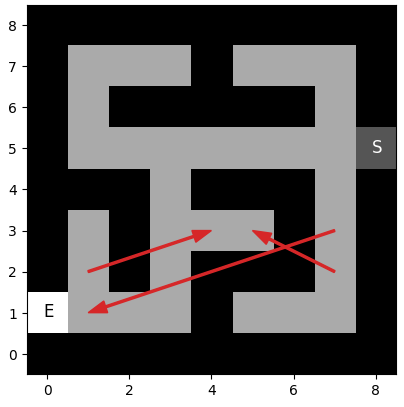

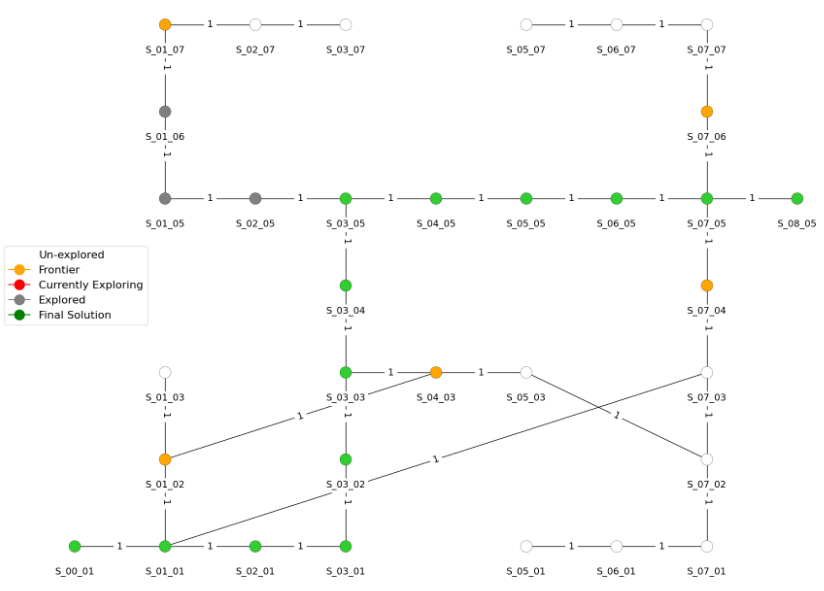

Curiously enough, in this case it was better not to take the wormhole:

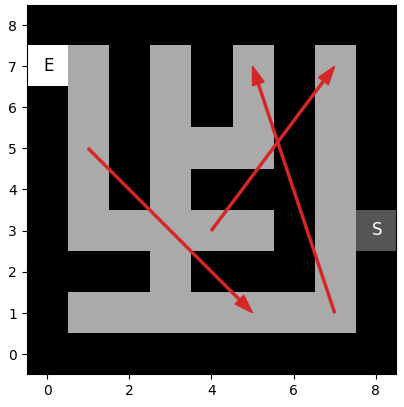

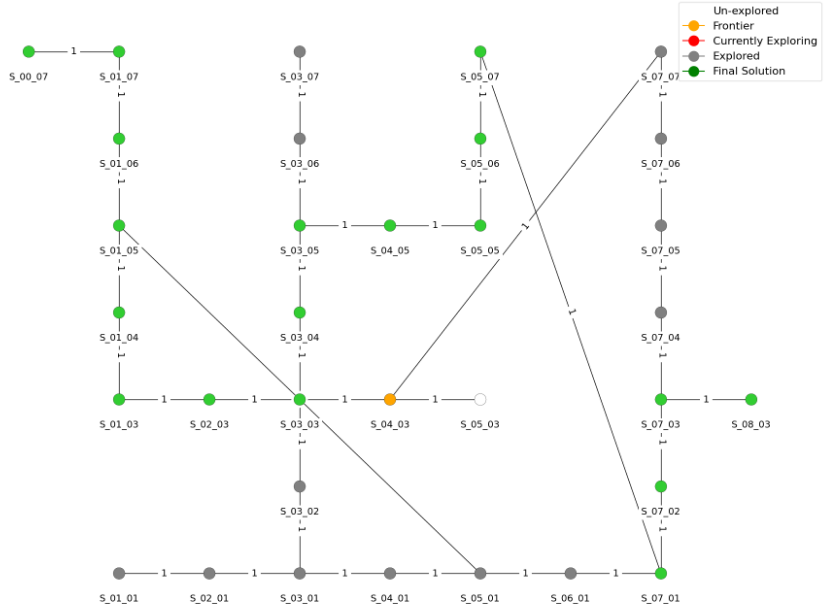

## Solving the problem (v1.0)

### Define the problem with no knowledge of the wormholes' exit

The A-star algorithm will always reach optimal solution if the heuristic function is admissible. 

A heuristic function is admissible if it never overestimates the cost to reach a goal. Meaning, an admissible h is optimistic, returning the estimated cost of the cheapest/shortest path from a state to the goal.

An agent at the start of a teleportation link can choose to go down the wormhole. However, it cannot know in advance where the exit is.

The most optimistic case going down a wormhole will always assume that a wormhole can take you right to the exit.

In [47]:
class WormholesGraphProblemV0(sch.GraphProblem):
    """The problem of searching a graph with teleportation links.
    
    An agent at the start of a teleportation link can choose to go down the wormhole.
    However, it cannot know in advance where the exit is.
    """

    def __init__(self, start, end, map, wormholes, verbose=False):
        super().__init__(start, end, map)
        self.wormholes = wormholes
        self.verbose = verbose

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def h(self, node, parent=None):
        """The sum of the horizontal and vertical distance to the goal"""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is not str:
                node = node.state
            if parent and type(parent) is not str:
                parent = parent.state
            position_node = np.array(locs[node])
            position_goal = np.array(locs[self.goal])
            if self.verbose: print("Node position", position_node)
            # The most optimistic assumption is that a wormhole will take you right adjacent to the goal
            if parent and node in self.wormholes:
                index = self.wormholes.index(node)
                if index>0 and parent==self.wormholes[index-1]:
                    if self.verbose: print("Teleportation link")
                    return 1 
            if self.verbose: 
                print("Distance to the goal", int( np.sum( np.abs( position_goal - position_node) ) ))
            return int( np.sum( np.abs( position_goal - position_node) ) )
        else:
            return sch.infinity

In [48]:
maze_problem = WormholesGraphProblemV0(maze_start, maze_end, maze_map, teleportation_links, verbose=True)

print("Initial state:", maze_problem.initial)
print("Goal state:", maze_problem.goal)
print("Teleportation links:", maze_problem.wormholes)

Initial state: S_08_05
Goal state: S_00_01
Teleportation links: ['S_05_07', 'S_02_01', 'S_01_03', 'S_07_02', 'S_03_03', 'S_07_06']


In [49]:
maze_problem.h(*maze_problem.wormholes[:2][::-1])

Node position [2 1]
Teleportation link


1

### Generalize A-star

In [54]:
import heapq
from aimautils import PriorityQueue

class DoublePriorityQueueV0(PriorityQueue):
    """A Queue in which elements are returned ordered according to f.
    
    If order is 'min', the item with minimum f(x) is returned first; if order is 
    'max', then it is the item with maximum f(x). Also supports dict-like lookup.

    In contrast with AIMA's implementation, this f can take optional arguments"""

    def append(self, item, *args):
        """Insert item at its correct position."""
        heapq.heappush(self.heap, (self.f(item, *args), item))

    def extend(self, items):
        raise NotImplementedError

    def pop(self):
        """Pop and return the item (with min or max f(x) value
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        """Return current capacity of PriorityQueue."""
        return len(self.heap)

    def __contains__(self, item):
        """Return True if item in PriorityQueue."""
        keys = [k for (_, k) in self.heap]
        return item in keys

    def __getitem__(self, key, *args):
        for _, item in self.heap:
            if item == key:
                return item

    def get_full_item(self, key):
        for _, item in self.heap:
            if item == key:
                return (_, item)

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        keys = [k for (_, k) in self.heap]
        index = keys.index(key)
        self.heap.remove(self.heap[index])
        heapq.heapify(self.heap)

In [61]:
def A_star_solver_v0(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned.
    
    Partial credit to the AI Module lecturers: this function has been 
    taken from Lab 3 before being modified.
    
    In contrast with the original...
    ...This function stores both node and parent inside of the queue
    ...It requires `DoublePriorityQueueV0` to work
    ...It's therefore meant to work on `WormholesGraphProblemV0` that can take 
    both node and parent to calculate the distance.
    """
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = sch.memoize(f, 'f')
    node = sch.Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "limegreen"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    # frontier = sch.PriorityQueue('min', f)
    frontier = DoublePriorityQueueV0('min', f)
    # frontier.append(node)
    frontier.append(node, None)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "limegreen"
            node_colors[problem.initial] = "limegreen"
            for extra_node in node.solution():
                node_colors[extra_node] = "limegreen"  
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                # frontier.append(child)
                frontier.append(child, node)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                # incumbent = frontier[child]
                current_f, incumbent = frontier.get_full_item(child)
                # if f(child) < f(incumbent):
                if f(child, node) < current_f:
                    del frontier[incumbent]
                    # frontier.append(child)
                    frontier.append(child, node)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [62]:
def wormholes_maze_A_star_solver_v0(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass.
    
    Credits to the AI Module lecturers: this function has been 
    taken from Lab 3 and it has not been modified"""
    h = sch.memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = A_star_solver_v0(
        problem, lambda node, parent : node.path_cost + h(node, parent)
    )
    return(iterations, all_node_colors, node)

### Run the solver

In [63]:
all_node_colors=[]
iterations, all_node_colors, node = wormholes_maze_A_star_solver_v0(maze_problem, h=None)

#-- Trace the solution --#
solution_path = [node]
cnode = node.parent
solution_path.append(cnode)
while cnode.state != maze_start:
    cnode = cnode.parent  
    solution_path.append(cnode)

print("----------------------------------------")
print("Identified goal state:"+str(solution_path[0]))
print("----------------------------------------")
print("Solution trace:"+str(solution_path))
print("----------------------------------------")


Node position [8 5]
Distance to the goal 12
Node position [7 5]
Distance to the goal 11
Node position [7 6]
Distance to the goal 12
Node position [6 5]
Distance to the goal 10
Node position [5 5]
Distance to the goal 9
Node position [5 4]
Distance to the goal 8
Node position [5 6]
Distance to the goal 10
Node position [4 5]
Distance to the goal 8
Node position [3 5]
Distance to the goal 7
Node position [2 5]
Distance to the goal 6
Node position [1 5]
Distance to the goal 5
Node position [5 3]
Distance to the goal 7
Node position [5 2]
Distance to the goal 6
Node position [4 3]
Distance to the goal 6
Node position [3 3]
Distance to the goal 5
Node position [2 3]
Distance to the goal 4
Node position [7 6]
Teleportation link
Node position [7 7]
Distance to the goal 13
Node position [1 3]
Distance to the goal 3
Node position [7 2]
Teleportation link
Node position [7 1]
Distance to the goal 7
Node position [7 3]
Distance to the goal 9
Node position [5 1]
Distance to the goal 5
Node position

### Visualization

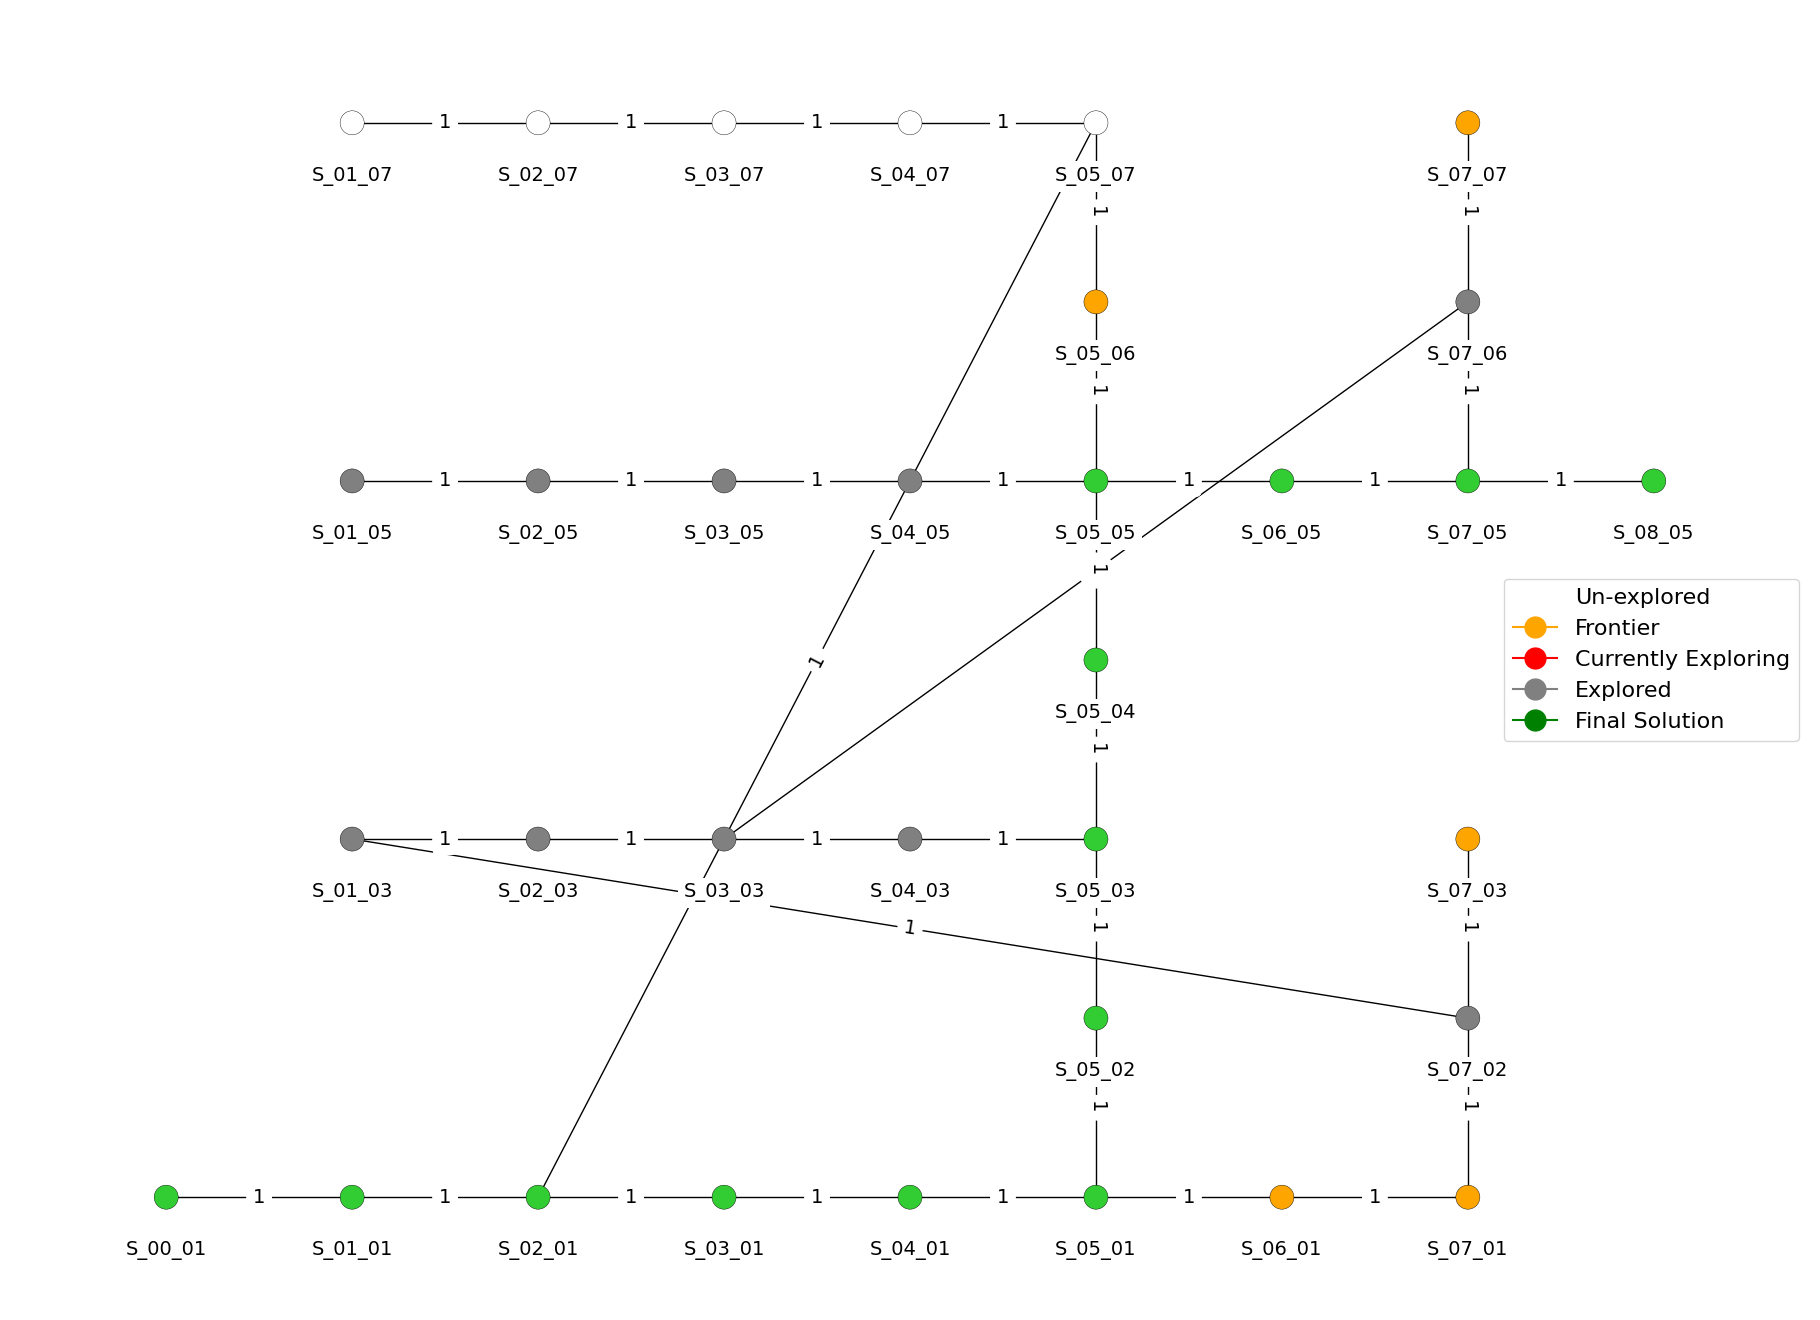

In [64]:
final_maze_graph_data = dict(maze_graph_data)
final_maze_graph_data["node_colors"] = all_node_colors[-1]

show_map(final_maze_graph_data)

In [ ]:
do_full_visualization = False
if do_full_visualization:     
    # WARNING the FULL visualisation might not work very well on some computers due to 
    # the large graph and the many iterations required.The visualisaiton will 
    # typically compute the solution and do the plotting at the end - and it often takes a long time ...
    #
    print("::: Full Visualization ::::")
    maze_problem.verbose = False
    all_node_colors = []        
    display_visual(maze_graph_data, user_input=False, 
               algorithm=my_A_star_solver, 
               problem=maze_problem)
    maze_problem.verbose = True

### Analysis

**I think the problem right now is that I am not updating my h function once I get to know a wormhole's exit.**

Apparently, the solution may not be optimal

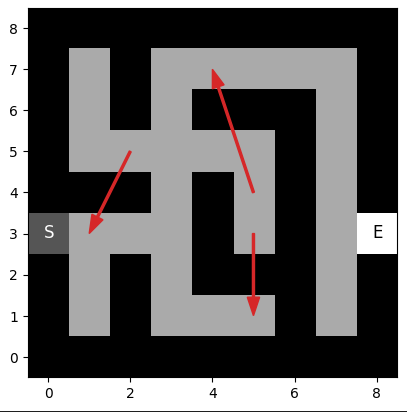

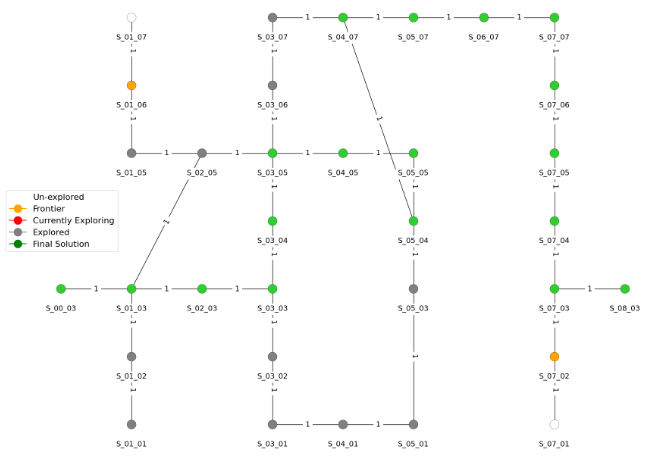

## Some previous ideas

### Solve using the original A-star

The cells below copy the A* implementation from Lab 3, using helper functions from the AIMA toolbox.


In [ ]:
def my_best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned.
    
    Credits to the AI Module lecturers: this function has been 
    taken from Lab 3 and it has not been modified"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = sch.memoize(f, 'f')
    node = sch.Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "limegreen"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = sch.PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "limegreen"
            node_colors[problem.initial] = "limegreen"
            for extra_node in node.solution():
                node_colors[extra_node] = "limegreen"  
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None


In [ ]:
def my_astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass.
    
    Credits to the AI Module lecturers: this function has been 
    taken from Lab 3 and it has not been modified"""
    h = sch.memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = my_best_first_graph_search_for_vis(problem, 
                                                                lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)

### Define the problem using the AIMA toolbox

According to the current setup...
- Cost function f = Accumulated path length, with each step uniformly assigned length 1 (wormholes included)
- Heuristic function h = Euclidian straight-line distance to the maze exit

However, to better represent the estimated remaining distance to the goal, it might be better to use a different distance metric: the sum $|x_{goal}-x| + |y_{goal}-y|$ of the vertical and horizontal distances.

In [42]:
class SquareAngleDistanceGraphProblem(sch.GraphProblem):
    """The problem of searching a graph from one node to another."""

    def __init__(self, *args, verbose=False):
        super().__init__(*args)
        self.verbose = verbose

    def h(self, node):
        """The sum of the horizontal and vertical distance to the goal"""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                state_position = np.array(locs[node])
            else:
                state_position = np.array(locs[node.state])
            goal_position = np.array(locs[self.goal])
            if self.verbose: 
                print("State position", state_position)
                print("Distance to the goal", int( np.sum( np.abs( goal_position - state_position) ) ))
            return int( np.sum( np.abs( goal_position - state_position) ) )
        else:
            return sch.infinity